In [61]:
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs
import re
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [65]:
staff = pd.read_csv("../staff_data/staff_raceeth_jobcategories_2010_2015.csv")
students = pd.read_csv("../student_data/student_raceeth_all.csv")
enrollment = pd.read_csv("../student_data/student_enrollment_all.csv", usecols = ["Org Code", "Year", "TOTAL"])
addresses = pd.read_csv("../student_data/school_addresses.csv", encoding = "ISO-8859-1", converters={'Zip Code': str}, usecols = ["Org Code", "Org Name", "Org Type", "Town", "Zip Code", "Grades"])
acs = pd.read_csv("../acs/acs_indicators_by_zip.csv", converters={'Zip Code': str}, usecols = ["Zip Code", "Median Income", "Percent Poverty", "% HS Graduates", "% College Graduates"])

In [66]:
# Remove "-" from ACS and convert to numeric
acs = acs.replace('-', np.NaN)
acs["Median Income"] = acs["Median Income"].apply(pd.to_numeric, errors='coerce')
acs["Percent Poverty"] = acs["Percent Poverty"].apply(pd.to_numeric, errors='coerce')

Calculate total number of nonwhite students and staff for weighted averages

In [67]:
enrollment = enrollment.rename(columns={"TOTAL": "Total Students"})
students = pd.merge(students, enrollment, on = ["Org Code", "Year"])
students['Nonwhite (Num Stu)'] = students["Total Students"] - (round(students['White']/100 * students['Total Students'], 0))
staff['Nonwhite (Num Staff)'] = staff["FTE Count"] - staff["White (# )"]

In [68]:
df = pd.merge(students, staff, how= "left", on= ['Org Code','Year'])

In [80]:
df = pd.merge(df, addresses, how= "inner", on = "Org Code")

In [81]:
## Keep necessary columns
df = df[["Org Code", "Org Type", "Year", "Job Category", "Nonwhite (Num Stu)", "Total Students", "Nonwhite (Num Staff)", "FTE Count"]]

In [82]:
# Remove state totals
df_job_mask = df["Org Code"] == 0
df_jobs = df[~df_job_mask]

In [83]:
df_jobs_grouped = df_jobs.groupby(["Job Category", "Org Type"]).sum()[["Nonwhite (Num Staff)", "FTE Count"]]

In [84]:
df_jobs_grouped["% Nonwhite Staff"] = round(df_jobs_grouped["Nonwhite (Num Staff)"] / df_jobs_grouped["FTE Count"] * 100, 1)

In [87]:
df_jobs_grouped.reset_index()

,Job Category,Org Type,Nonwhite (Num Staff),FTE Count,% Nonwhite Staff
0,Administrative Support,Charter School,595.2,1746.0,34.1
1,Administrative Support,Public School,2598.7,31716.1,8.2
2,All Staff,Charter School,4576.3,23120.1,19.8
3,All Staff,Public School,49212.4,649569.0,7.6
4,District Leaders,Charter School,63.8,341.4,18.7
5,District Leaders,Public School,90.6,1774.5,5.1
6,Health,Charter School,61.2,349.0,17.5
7,Health,Public School,446.4,10491.0,4.3
8,Paraprofessionals,Charter School,722.7,2518.0,28.7
9,Paraprofessionals,Public School,14789.5,130270.5,11.4


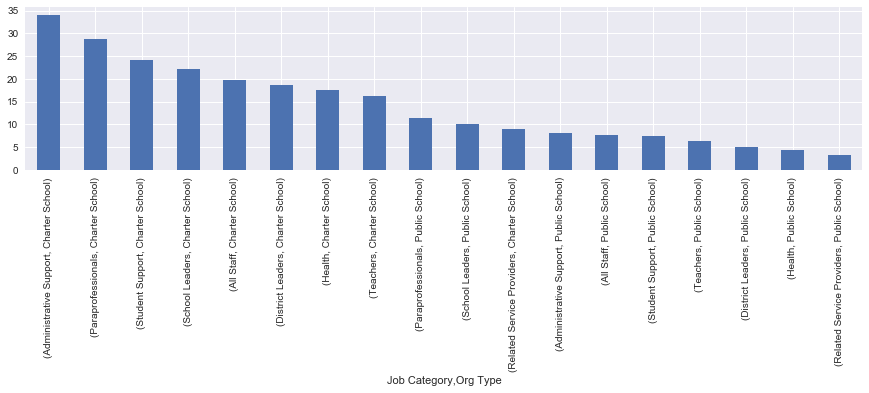

In [88]:
job = df_jobs_grouped["% Nonwhite Staff"].sort_values(ascending = False).plot(kind = "bar", figsize = (15, 3))

In [91]:
## Examine trends over time
year_grouped = df.groupby(["Year", "Org Type"]).sum()[["Nonwhite (Num Stu)", "Total Students", "Nonwhite (Num Staff)", "FTE Count"]]

In [92]:
year_grouped['Perc Nonwhite Students'] = year_grouped['Nonwhite (Num Stu)'] / year_grouped['Total Students'] * 100
year_grouped['Perc Nonwhite Staff'] = year_grouped['Nonwhite (Num Staff)'] / year_grouped['FTE Count'] * 100

In [93]:
year_grouped = year_grouped.reset_index()

In [94]:
year_grouped

,Year,Org Type,Nonwhite (Num Stu),Total Students,Nonwhite (Num Staff),FTE Count,Perc Nonwhite Students,Perc Nonwhite Staff
0,2010,Charter School,134559.0,232866,1194.7,6498.3,57.783876,18.384808
1,2010,Public School,2341881.0,7930944,15909.5,211654.0,29.528402,7.516749
2,2011,Charter School,140292.0,241155,1273.2,6772.2,58.175033,18.800390
3,2011,Public School,2423151.0,7928865,15764.1,209988.5,30.561133,7.507125
4,2012,Charter School,152136.0,255591,1402.5,7263.5,59.523223,19.308873
5,2012,Public School,2535345.0,7981803,16249.5,213229.3,31.764064,7.620669
6,2013,Charter School,164106.0,269865,1516.3,7819.2,60.810405,19.392009
7,2013,Public School,2622051.0,8014023,16866.1,217587.4,32.718286,7.751414
8,2014,Charter School,187713.0,296559,1730.1,8430.3,63.297017,20.522401
9,2014,Public School,2716492.0,8057532,16427.3,220874.1,33.713698,7.437404


In [97]:
charter_mask = year_grouped["Org Type"] == "Charter School"
year_grouped_charter = year_grouped[charter_mask]
year_grouped_public = year_grouped[~charter_mask]

(0, 75)

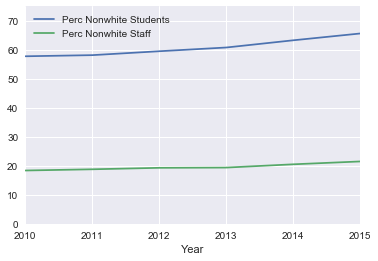

In [102]:
ax = year_grouped_charter[['Year', 'Org Type', 'Perc Nonwhite Students', 'Perc Nonwhite Staff']].set_index('Year').plot()
ax.set_ylim(ymin = 0, ymax = 75)

(0, 75)

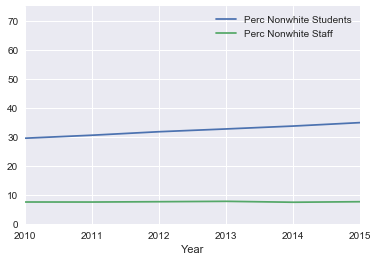

In [101]:
ax = year_grouped_public[['Year', 'Org Type', 'Perc Nonwhite Students', 'Perc Nonwhite Staff']].set_index('Year').plot()
ax.set_ylim(ymin = 0, ymax = 75)

In [103]:
## Group all staff and students on Zip Code
staff_mask = df["Job Category"] == "All Staff"
df_staff = df[staff_mask]

In [104]:
df_zip = pd.merge(df_staff, addresses, how = "inner", on = "Org Code")
df_zip = df_zip.fillna(0)

In [105]:
zip_grouped = df_zip.groupby("Zip Code").sum()[["Nonwhite (Num Stu)", "Total Students", "Nonwhite (Num Staff)", "FTE Count"]]

In [106]:
zip_grouped['Perc Nonwhite Students'] = zip_grouped['Nonwhite (Num Stu)'] / zip_grouped['Total Students'] * 100
zip_grouped['Perc Nonwhite Staff'] = zip_grouped['Nonwhite (Num Staff)'] / zip_grouped['FTE Count'] * 100

In [107]:
zip_grouped = zip_grouped.reset_index()

In [108]:
df_zip = pd.merge(zip_grouped, acs, how = "inner", on = "Zip Code")

In [109]:
df_zip.columns

Index(['Zip Code', 'Nonwhite (Num Stu)', 'Total Students',
       'Nonwhite (Num Staff)', 'FTE Count', 'Perc Nonwhite Students',
       'Perc Nonwhite Staff', 'Median Income', 'Percent Poverty',
       '% HS Graduates', '% College Graduates'],
      dtype='object')

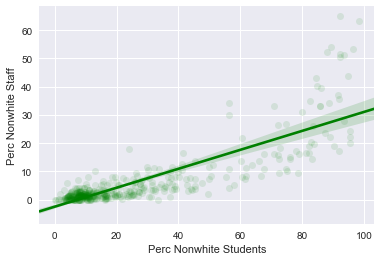

In [110]:
sns.regplot(x = "Perc Nonwhite Students", y = "Perc Nonwhite Staff", data = df_zip, color="green", scatter_kws = {"alpha" : 0.1,});

In [114]:
## Don't think this is more interesting than the school level regression

ols = smf.ols(formula = "perc_nw_staff ~ perc_nw_stu + hs_grad + med_income + college_grad + perc_poverty",
              data = df_zip.rename(columns = {"Perc Nonwhite Students" : "perc_nw_stu", 
                                              "Perc Nonwhite Staff"  : "perc_nw_staff",
                                              "Median Income": "med_income",
                                              "Percent Poverty": "perc_poverty",
                                              "% HS Graduates": "hs_grad",
                                             "% College Graduates": "college_grad"}))
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          perc_nw_staff   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     196.2
Date:                Mon, 27 Nov 2017   Prob (F-statistic):          5.12e-107
Time:                        19:07:08   Log-Likelihood:                -1327.4
No. Observations:                 422   AIC:                             2667.
Df Residuals:                     416   BIC:                             2691.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -10.1915      6.950     -1.466      0.143     -23.854       3.471
perc_nw_stu      0.3312      0.017     19.583      0.000       0.298       0.364
hs_grad          0.0690      0.077      0.901      0.368      -0.081       0.219
med_income   -2.532e-05   1.73e-05     -1.464      0.144   -5.93e-05    8.68e-06
college_grad     0.0729      0.030      2.450      0.015       0.014       0.131
perc_poverty     0.0411      0.040      1.016      0.310      -0.038       0.121
==============================================================================
Omnibus:                      225.107   Durbin-Watson:                   0.823
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2174.104
Skew:                           2.081   Prob(JB):                         0.00
Kurtosis:                      13.311   Cond. No.                     2.10e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""